# Taller 4

Felipe Palacios,  Santiago Segura, Vihlai Maldonado

## Objetivo
Evaluar las capacidades del estudiante para desplegar modelos analíticos mediante una API REST como mecanismo para disponibilizar/integrar un proceso básico de inferencia dentro de una aplicación web o móvil.
## Planteamiento del problema
El área de fidelización de una empresa de telecomunicaciones tiene como uno de sus objetivos disminuir la tasa de churn (abandono) por parte de sus clientes. Por esta razón, desea construir un modelo de machine learning que permita predecir si un cliente es propenso abandonar los servicios que actualmente tiene contratados con la empresa. Una vez construido, este modelo debe ser disponibilizado a través de una API REST que pueda ser consumida por la plataforma que es usada por los asesores de call center usando dicha predicción para ofrecer nuevos productos o servicios para los clientes más propensos al abandono.
## Diccionario de datos:

| Field            | Description                                                                                                        |
|------------------|--------------------------------------------------------------------------------------------------------------------|
| customerID       | Customer ID                                                                                                        |
| gender           | Whether the customer is a male or a female                                                                         |
| SeniorCitizen    | Whether the customer is a senior citizen or not (1, 0)                                                             |
| Partner          | Whether the customer has a partner or not (Yes, No)                                                                |
| Dependents       | Whether the customer has dependents or not (Yes, No)                                                               |
| tenure           | Number of months the customer has stayed with the company                                                          |
| PhoneService     | Whether the customer has a phone service or not (Yes, No)                                                          |
| MultipleLines    | Whether the customer has multiple lines or not (Yes, No, No phone service)                                         |
| InternetService  | Customer’s internet service provider (DSL, Fiber optic, No)                                                        |
| OnlineSecurity   | Whether the customer has online security or not (Yes, No, No                                                       |
| OnlineBackup     | Whether the customer has online backup or not (Yes, No, No internet service)                                       |
| DeviceProtection | Whether the customer has device protection or not (Yes, No, No internet service)                                   |
| TechSupport      | Whether the customer has tech support or not (Yes, No, No internet service)                                        |
| StreamingTV      | Whether the customer has streaming TV or not (Yes, No, No internet service)                                        |
| StreamingMovies  | Whether the customer has streaming movies or not (Yes, No, No internet service)                                    |
| Contract         | The contract term of the customer (Month-to-month, One year, Two year)                                             |
| PaperlessBilling | Whether the customer has paperless billing or not (Yes, No)                                                        |
| PaymentMethod    | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) |
| MonthlyCharges   | The amount charged to the customer monthly                                                                         |
| TotalCharges     | The total amount charged to the customer                                                                           |
| Churn            | Whether the customer churned or not (Yes or No)                                                                    

In [163]:
!pip -q install markupsafe==2.0.1

In [330]:
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import pandas as pd
import missingno as msno
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
import numpy as np
from copy import deepcopy
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_auc_score

## Integración del proceso de transformación de datos, entrenamiento y predicción

In [165]:
data_df = pd.read_json('https://raw.githubusercontent.com/MaldonadoVihlai/taller_cda/main/taller4/data/DataSet_Entrenamiento_v1.json')
data_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,5386-THSLQ,Female,1,Yes,No,66,No,No phone service,DSL,No,...,Yes,No,Yes,No,One year,No,Bank transfer (automatic),45.55,3027.25,No
4,3192-NQECA,Male,0,Yes,No,68,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),110.00,7611.85,Yes


Exploración y análisis de calidad de datos

### Registros duplicados

In [166]:
data_df[data_df.duplicated(keep=False)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Se observa que el dataset no contiene registros duplicados.

### Valores nulos

In [167]:
null_data_df = data_df[data_df.isnull().any(axis=1)]
null_data_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


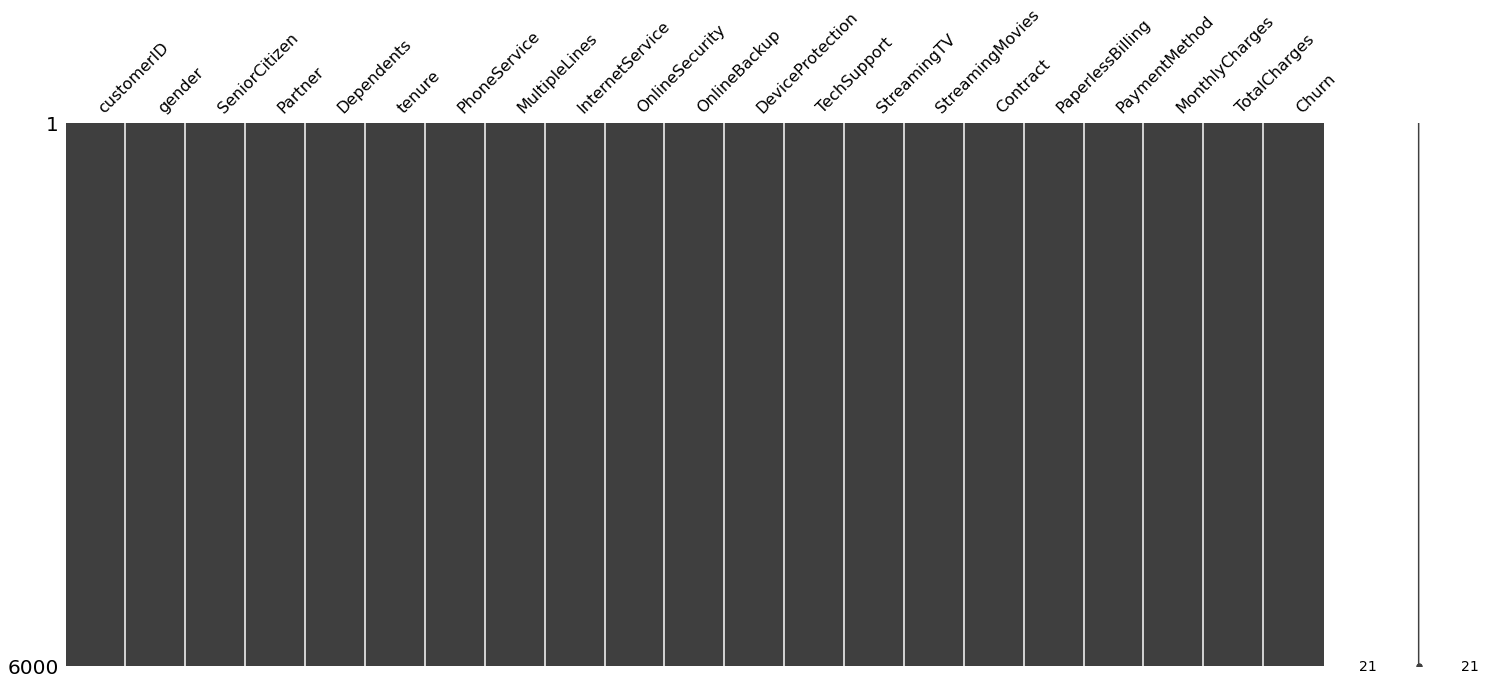

In [168]:
msno.matrix(data_df)

El dataset no contiene registros nulos o vacíos.

In [169]:
def plot_count_plot_percentages(data_df, column):
  ax = sns.countplot(data=data_df, x=column, color="teal")
  ax.set(title = 'Distribución de la variable ' + column)
  total = float(len(data_df[column]))
  for p in ax.patches:
      percentage = '{:.1f}%'.format(100 * p.get_height()/total)
      x = p.get_x() + p.get_width()
      y = p.get_height()
      ax.annotate(percentage, (x, y),ha='center')
  plt.show()
def plot_hist_box(data_df, column):
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  sns.histplot(data_df[column], color="gold", ax=axs[0]).set(title='Histograma de ' + column)
  sns.boxplot(data=data_df, x=column, ax=axs[1]).set(title='Box Plot de ' + column)

Variable `gender`

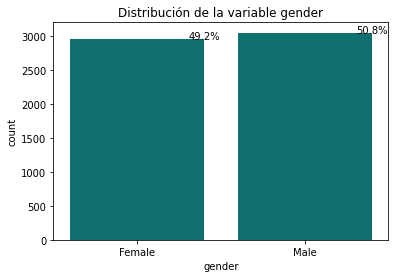

In [170]:
plot_count_plot_percentages(data_df, 'gender')

El 50.8% de los clientes son hombres.

Variable `SeniorCitizen`

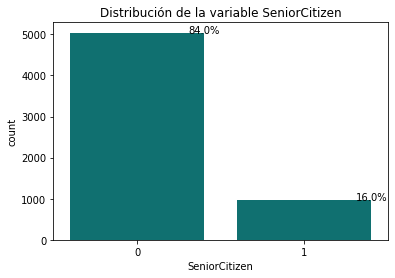

In [171]:
plot_count_plot_percentages(data_df, 'SeniorCitizen')

El 84% de los clientes no son jubilados.

Variable `Partner`

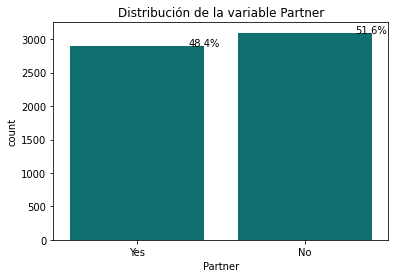

In [172]:
plot_count_plot_percentages(data_df, 'Partner')

El 51.6% de los clientes no son Partner.

Variable `Dependents`

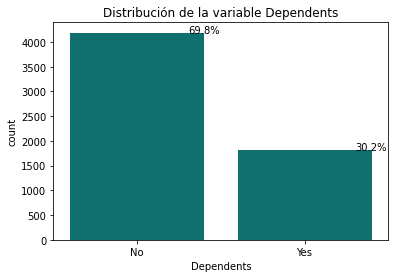

In [173]:
plot_count_plot_percentages(data_df, 'Dependents')

El 69.8% de los clientes no tiene dependientes.

Variable `tenure`

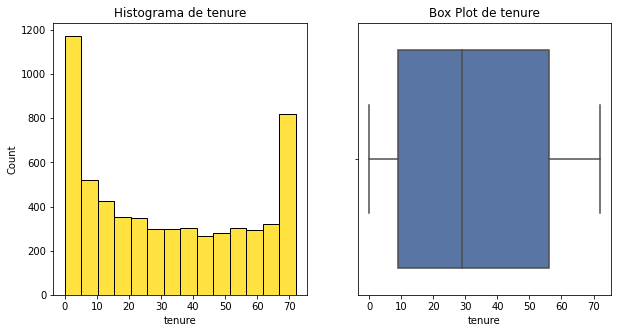

In [227]:
plot_hist_box(data_df, 'tenure')

In [229]:
data_df['tenure'].describe()

count    6000.000000
mean       32.320667
std        24.637296
min         0.000000
25%         9.000000
50%        29.000000
75%        56.000000
max        72.000000
Name: tenure, dtype: float64

La variable se distribuye tomando valores discretos entre 0 y 72 meses. La media es de 32.3 meses y de acuerdo al diagrama de cajas la variable no presenta valores atípicos.

Variable `PhoneService`

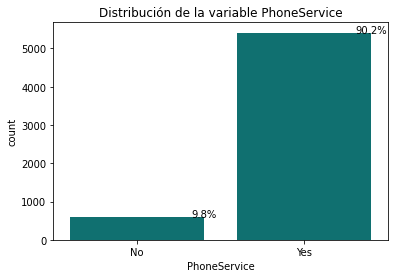

In [175]:
plot_count_plot_percentages(data_df, 'PhoneService')

El 90.2% de los clientes tiene un servicio de teléfono.

Variable `MultipleLines`

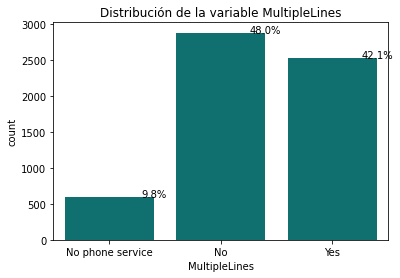

In [176]:
plot_count_plot_percentages(data_df, 'MultipleLines')

El 48% de los usuarios no tiene múltiples líneas y el 42.1% si las tiene.

Variable `InternetService`

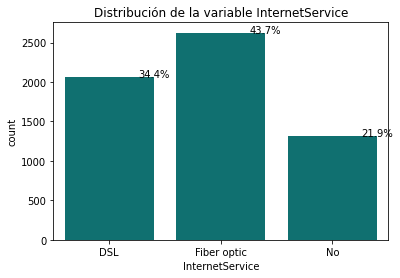

In [177]:
plot_count_plot_percentages(data_df, 'InternetService')

Los servicios de internet que ofrece la compañía son DSL y fibra óptica. El 34.4% de los clientes tiene un servicio de interet DSL y el 43.7% de fibra óptica.

Variable `OnlineSecurity`

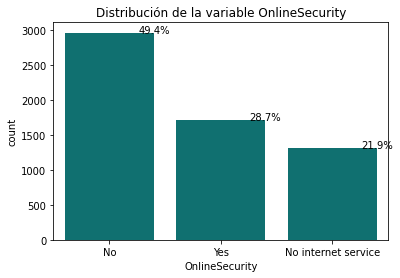

In [178]:
plot_count_plot_percentages(data_df, 'OnlineSecurity')

El servicio de seguridad online se ofece a clientes con internet, sólo el 28.7% de los clientes tienen este servicio.

Variable `OnlineBackup`

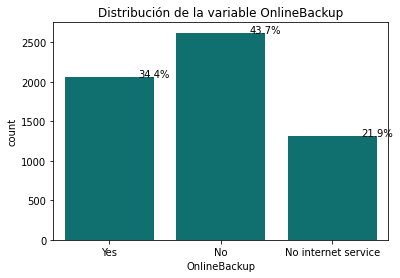

In [179]:
plot_count_plot_percentages(data_df, 'OnlineBackup')

El servicio de backup online se ofece a clientes con internet, sólo el 34.4% de los clientes tienen este servicio.

Variable `DeviceProtection`

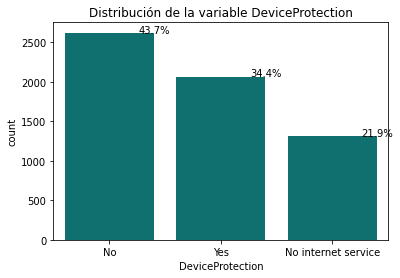

In [180]:
plot_count_plot_percentages(data_df, 'DeviceProtection')

El servicio de protección de dispositivos se ofece a clientes con internet, sólo el 34.4% de los clientes tienen este servicio.

Variable `TechSupport`

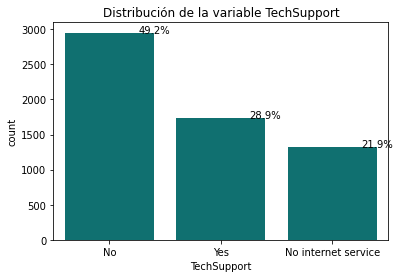

In [181]:
plot_count_plot_percentages(data_df, 'TechSupport')

El servicio de soporte técnico se ofece a clientes con internet, sólo el 28.9% de los clientes tienen este servicio.

Variable `StreamingTV`

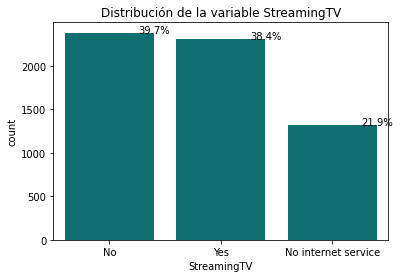

In [182]:
plot_count_plot_percentages(data_df, 'StreamingTV')

Variable `StreamingMovies`

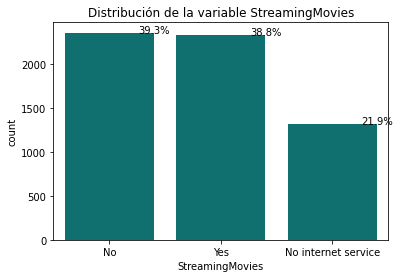

In [183]:
plot_count_plot_percentages(data_df, 'StreamingMovies')

Variable `Contract`

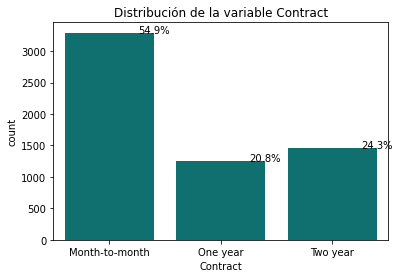

In [184]:
plot_count_plot_percentages(data_df, 'Contract')

Sólo el 20.8% de los clientes tiene un contrato a 1 año.

Variable `PaperlessBilling`

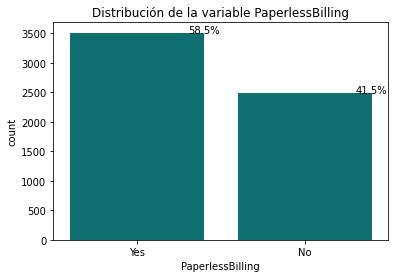

In [185]:
plot_count_plot_percentages(data_df, 'PaperlessBilling')

Variable `PaymentMethod`

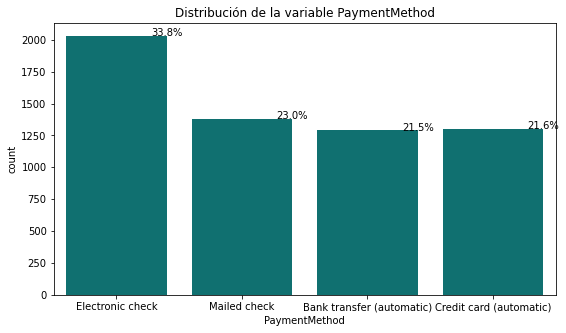

In [186]:
fig, ax = plt.subplots(figsize=(9, 5))
plot_count_plot_percentages(data_df, 'PaymentMethod')

El 33.8% de los clientes realizan pago electrónico y el 21.6% con tarjeta de crédito.

Variable `MonthlyCharges`

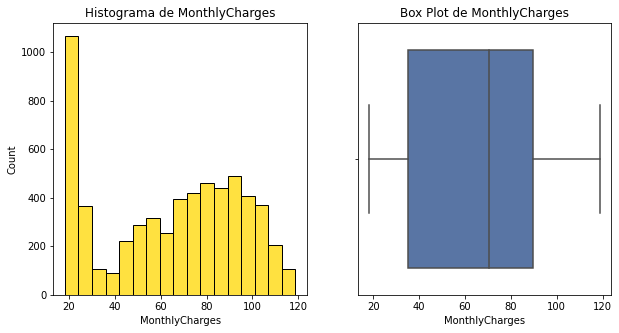

In [187]:
plot_hist_box(data_df, 'MonthlyCharges')

In [188]:
data_df['MonthlyCharges'].describe()

count    6000.000000
mean       64.607233
std        30.195382
min        18.250000
25%        35.000000
50%        70.300000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

La variable se distribuye entre 64.6 y 118.La media es de 64.6. De acuerdo al diagrama de cajas no presenta valores atípicos. 

Variable `TotalCharges`

[Text(0.5, 1.0, 'Box Plot de TotalCharges')]

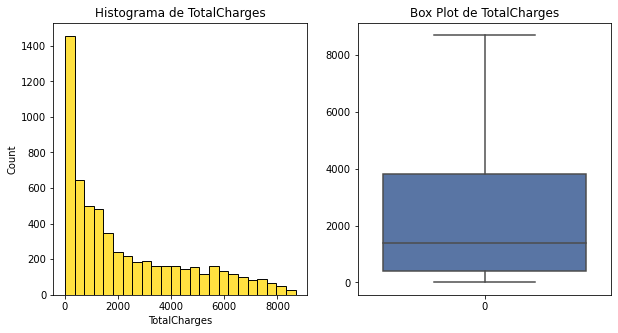

In [189]:
#Se aplicará una modificación al dataset sólamente para graficarlo, las transformaciones se aplican en la siguiente sección con el objeto Pipeline de sklearn
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data_df['TotalCharges'].replace('', 0).astype(float), color="gold", ax=axs[0]).set(title='Histograma de TotalCharges')
sns.boxplot(data=data_df['TotalCharges'].replace('', 0).astype(float), ax=axs[1]).set(title='Box Plot de TotalCharges')

In [232]:
data_df['TotalCharges'].replace('', 0).describe()

count    6000.000000
mean     2278.184842
std      2274.410916
min         0.000000
25%       385.812500
50%      1389.725000
75%      3796.912500
max      8684.800000
Name: TotalCharges, dtype: float64

La variable se distribuye entre 0 y 8684.8, la media es de 2278.18. De acuerdo al diagrama de cajas no presenta valores atípicos.

Variable `Churn`

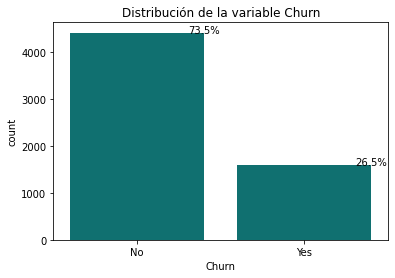

In [190]:
plot_count_plot_percentages(data_df, 'Churn')

La variable objetivo es binaria, y las clases están desbalanceados, tenemos el 73.5% con **No** y sólo el 26.5% con **Si**.

A continuación se define el pipeline para el procesamiento de datos.

In [192]:
data_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [233]:
class CleanTransformer(BaseEstimator, TransformerMixin):
  # add another additional parameter, just for fun, while we are at it
  def __init__(self, feature_name):
    self.feature_name = feature_name

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    X_[self.feature_name] = X_[self.feature_name].replace('', 0)
    return X_

In [387]:
#TODO: el entrenamiento es con Pipeline también? Si
categorical_features = ["MultipleLines", 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

x_columns_ordinal = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ('ord_encoder', OrdinalEncoder(), x_columns_ordinal),
    ], remainder = 'passthrough'
)

x_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

processing_pipe = Pipeline([
    ('cleaning_column', CleanTransformer('TotalCharges')),
    ('columnsTransformer', preprocessor),
    ("selector", ColumnTransformer([("selector", "passthrough", list(range(1,21,1)))], remainder="drop")),
    ("scaler", StandardScaler()),
    # ("classifier", LogisticRegression())
    ])

objective_variable_pipe = Pipeline([
    ("selector", ColumnTransformer([("selector", "passthrough", [20])], remainder="drop")),
    ])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(data_df.drop('Churn', axis=1), data_df['Churn'], test_size = 0.2, random_state=1)
X_train, X_val, Y_train, y_val= train_test_split(X_train, Y_train, test_size = 0.2, random_state=1)

processing_pipe.fit(X_train)
X_train_processed = processing_pipe.transform(X_train)
print(X_train_processed)
processing_pipe

[[-0.33333333 -0.83164293 -0.73758318 ... -0.81826965  1.88838366
  -0.78279483]
 [-0.33333333 -0.83164293  1.35577929 ...  1.22209103 -0.52955341
  -0.78279483]
 [-0.33333333  1.20243913 -0.73758318 ...  1.22209103 -0.52955341
  -0.78279483]
 ...
 [-0.33333333 -0.83164293 -0.73758318 ... -0.81826965  1.88838366
  -0.78279483]
 [-0.33333333  1.20243913 -0.73758318 ... -0.81826965 -0.52955341
   1.27747395]
 [-0.33333333  1.20243913 -0.73758318 ...  1.22209103 -0.52955341
  -0.78279483]]


Pipeline(steps=[('cleaning_column',
                 CleanTransformer(feature_name='TotalCharges')),
                ('columnsTransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod']),
                                                 ('ord_encoder',
                                                  OrdinalEncoder(),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'PaperlessBilling'])])),
                ('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20])])),
                ('scaler', StandardScaler())])

In [388]:
#Aplicamos la transformación a la variable y:
class TransformNumericTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X_ = X.copy()
    X_ = X_.replace({'Yes':1, 'No':0})
    return X_
transform_numeric_pipe = Pipeline([
    ('cleaning_column', TransformNumericTransformer())
])
Y_train = transform_numeric_pipe.transform(Y_train)
y_val = transform_numeric_pipe.transform(y_val)
Y_test = transform_numeric_pipe.transform(Y_test)

## Búsqueda automática del mejor modelo
Realice una búsqueda en grilla con validación cruzada con al menos 3 algoritmos y sus
respectivos conjuntos de hiper-parámetros para encontrar el mejor modelo de
clasificación de churn optimizando la métrica ROC AUC. Tenga en cuenta lo siguiente:
* Este proceso debe realizarse DataSet_Entrenamiento_v1.txt. solamente sobre el archivo
* Recuerde que dentro de la búsqueda en grilla también puede hacer selección de
modelo para diferentes alternativas de transformación de datos. Si el espacio de
búsqueda se vuelve muy amplio, puede optar por una búsqueda aleatoria.
* Detalle los aspectos más relevantes del mejor modelo encontrado y sus resultados de diferentes métricas para los datasets de entrenamiento, validación y prueba
* Responda la pregunta: ¿Se evidencian problemas de overfitting o underfitting?
* Investigue y describa por qué es preferible la métrica ROC AUC sobre las demás
métricas como F1, Precision o Recall.
* Exporte el mejor modelo obtenido a un archivo tipo pickle o joblib.

In [389]:
def print_confusion_and_roc_auc_metrics(grid_search_clf, X_df, y_df):
  best_base = grid_search_clf.best_estimator_
  print(grid_search_clf.best_params_)
  predictions = best_base.predict(X_df)
  print("Matriz de confusión:")
  print(classification_report(y_df, predictions))
  print("ROC AUC:")
  print(roc_auc_score(y_df, predictions))

### LogisticRegression

In [390]:
processing_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cleaning_column', 'columnsTransformer', 'selector', 'scaler', 'cleaning_column__feature_name', 'columnsTransformer__n_jobs', 'columnsTransformer__remainder', 'columnsTransformer__sparse_threshold', 'columnsTransformer__transformer_weights', 'columnsTransformer__transformers', 'columnsTransformer__verbose', 'columnsTransformer__verbose_feature_names_out', 'columnsTransformer__cat', 'columnsTransformer__ord_encoder', 'columnsTransformer__cat__categories', 'columnsTransformer__cat__drop', 'columnsTransformer__cat__dtype', 'columnsTransformer__cat__handle_unknown', 'columnsTransformer__cat__sparse', 'columnsTransformer__ord_encoder__categories', 'columnsTransformer__ord_encoder__dtype', 'columnsTransformer__ord_encoder__handle_unknown', 'columnsTransformer__ord_encoder__unknown_value', 'selector__n_jobs', 'selector__remainder', 'selector__sparse_threshold', 'selector__transformer_weights', 'selector__transformers', 'selector__verbose', 'selector__v

In [391]:
processing_pipe.steps.append(["classifier",  LogisticRegression(max_iter=10000, tol=0.1)])
grid={"classifier__C":np.logspace(-4, 4, 4), "classifier__penalty":["l2"], "classifier__max_iter": [1000, 5000, 10000, 100000]}

grid_search_log = GridSearchCV(processing_pipe,grid,cv=5)
grid_search_log.fit(X_train, Y_train)
grid_search_log.best_params_
processing_pipe.steps.pop(-1)

['classifier', LogisticRegression(max_iter=10000, tol=0.1)]

In [392]:
print_confusion_and_roc_auc_metrics(grid_search_log, X_val, y_val)

{'classifier__C': 0.046415888336127774, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2'}
Matriz de confusión:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       698
           1       0.58      0.32      0.41       262

    accuracy                           0.75       960
   macro avg       0.68      0.62      0.63       960
weighted avg       0.73      0.75      0.72       960

ROC AUC:
0.6154170038714757


Se aplica SMOTE:

In [393]:
processing_pipe.steps.append(['sampling', SMOTE()])
processing_pipe.steps.append(["classifier",  LogisticRegression(max_iter=10000, tol=0.1)])
grid={"classifier__C":np.logspace(-4, 4, 4), "classifier__penalty":["l2"], "classifier__max_iter": [1000, 5000, 10000, 100000]}

grid_search_log = GridSearchCV(processing_pipe,grid,cv=5)
grid_search_log.fit(X_train, Y_train)
grid_search_log.best_params_
processing_pipe.steps.pop(-1)
processing_pipe.steps.pop(-1)

['sampling', SMOTE()]

In [394]:
print_confusion_and_roc_auc_metrics(grid_search_log, X_val, y_val)

{'classifier__C': 0.046415888336127774, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2'}
Matriz de confusión:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       698
           1       0.49      0.75      0.60       262

    accuracy                           0.72       960
   macro avg       0.69      0.73      0.69       960
weighted avg       0.78      0.72      0.73       960

ROC AUC:
0.7305387256939129


Model2

Model3